In [349]:
import os
import sys
import glob
import tqdm
import random
import librosa
import numpy as np
import pandas as pd
import librosa.display
import IPython.display as ipd
from tqdm import tqdm_notebook
from matplotlib import patches
from matplotlib import pyplot as plt
from pydub import AudioSegment
from pydub.playback import play
import warnings
warnings.filterwarnings('ignore')

In [7]:
def load_audio_file(file_path):
    data = librosa.core.load(file_path)[0]
    return data

def plot_time_series(data):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()

In [2]:
dataset_dir = "/home/ubuntu/Notebooks/Antispoofing"
train_dataset_dir = os.path.join(dataset_dir, "audio")
wav_paths = sorted(glob.glob(os.path.join(train_dataset_dir, '**/*.wav'), recursive=True))

In [370]:
audio = random.choice(wav_paths)
data = load_audio_file(audio)

In [371]:
ipd.Audio(data, rate=20000)

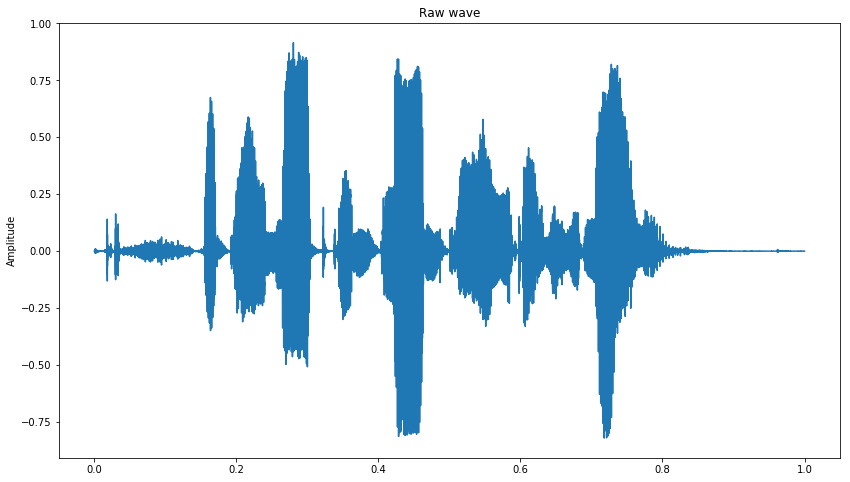

In [369]:
plot_time_series(data)

__1.__ - Добавление шума<br>
__2.__ - Перемешивани по секундам<br>
__3.__ - Ускорение/замедление<br>
__4.__ - Изменение тона<br>
__5.__ - Обрезка тишины

# 1.

In [24]:
def add_noise(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [30]:
ipd.Audio(add_noise(data, 0.005), rate=20000)

# 2. 

In [225]:
def roll(data):
    data_roll = np.roll(data, random.randint(int(len(data) * 0.2), len(data)))
    return data_roll
ipd.Audio(roll(data), rate=20000)

# 3.

In [69]:
def add_speed(data, speed_factor):
    return librosa.effects.time_stretch(data, speed_factor)

In [318]:
ipd.Audio(add_speed(data, 0.8), rate=20000)

# 4.

In [76]:
def tonality(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [86]:
ipd.Audio(tonality(data, 2,9), rate=20000)

# 5.

In [219]:
def del_silence(data):
    a,b = librosa.effects.trim(data, top_db=30)
    return a    

In [220]:
ipd.Audio(del_silence(data), rate=20000)

<hr>

# hpss

Decompose an audio time series into harmonic and percussive components.

In [91]:
harmonic, percussive = librosa.effects.hpss(data)

In [95]:
ipd.Audio(percussive, rate=20000)

In [96]:
ipd.Audio(harmonic, rate=20000)

<hr>

# augmentation generator

In [372]:
def make_augm(data): 
    func_list = [add_noise, roll, add_speed ,tonality , del_silence]
    augm_data = data 
    for i in range(0,3):
        f = random.choice(func_list)
        
        if f == add_noise:
            augm_data = f(augm_data, round(random.uniform(0, 0.01),5))
            
        if f == roll:
            augm_data = f(augm_data)
            
        if f == add_speed:
            augm_data = f(augm_data, round(random.uniform(0.8,1.5), 2))
            
        if f == tonality:
            augm_data = f(augm_data, random.randint(1,3), random.randint(1,3))
            
        if f == del_silence:
            augm_data = f(augm_data)
            func_list.remove(f)
            
    return augm_data

In [373]:
augm_100 = []

In [374]:
%%time
for _ in tqdm_notebook(range(10)):
    a = make_augm(data)
    augm_100.append(a)


CPU times: user 3.23 s, sys: 7.92 ms, total: 3.24 s
Wall time: 3.23 s


In [375]:
import scipy

In [379]:
for a, rec in enumerate(augm_100):
    scipy.io.wavfile.write('augm_audios/augm_audio{}.wav'.format(a), 20000, rec)